In [59]:
# Data Set voorbereiden
import warnings
import pandas as pd
import pyodbc
warnings.simplefilter('ignore')

DBAdventureWorks = {"servername": "localhost\SQLEXPRESS",
      "database": "AdventureWorks2019"}
DBaenc = {"servername": "localhost\SQLEXPRESS",
      "database": "aenc"}
DBNorthwind = {"servername": "localhost\SQLEXPRESS",
      "database": "Northwind"}


export_connAdventureWorks = pyodbc.connect('DRIVER={SQL Server};SERVER=' + DBAdventureWorks['servername'] + 
                             ';DATABASE=' + DBAdventureWorks['database'] + ';Trusted_Connection=yes')
export_connaenc = pyodbc.connect('DRIVER={SQL Server};SERVER=' + DBaenc['servername'] + 
                             ';DATABASE=' + DBaenc['database'] + ';Trusted_Connection=yes')
export_connNorthwind = pyodbc.connect('DRIVER={SQL Server};SERVER=' + DBNorthwind['servername'] + 
                             ';DATABASE=' + DBNorthwind['database'] + ';Trusted_Connection=yes')

export_cursorAdventureWorks = export_connAdventureWorks.cursor()
export_cursoraenc = export_connaenc.cursor()
export_cursorNorthwind = export_connNorthwind.cursor()








# data ophalen

In [60]:
adventureworks_customers = pd.read_sql_query("SELECT * FROM Sales.Customer", export_connAdventureWorks)
adventureworks_orders = pd.read_sql_query("SELECT * FROM Sales.SalesOrderHeader", export_connAdventureWorks)

aenc_customers = pd.read_sql_query("SELECT * FROM customer", export_connaenc)
aenc_orders = pd.read_sql_query("SELECT * FROM sales_order", export_connaenc)


northwind_customers = pd.read_sql_query("SELECT * FROM Customers", export_connNorthwind)
northwind_orders = pd.read_sql_query("SELECT * FROM Orders", export_connNorthwind)


# Data verwerken 

In [61]:
# Combineer klantgegevens met ordergegevens om de OrderDate en andere gegevens te krijgen
adventureworks_orders = adventureworks_orders.merge(adventureworks_customers, on='CustomerID', how='left')

# Selecteer en hernoem de relevante kolommen
adventureworks_orders = adventureworks_orders[['CustomerID', 'OrderDate']]
adventureworks_orders['Source'] = 'AdventureWorks2019'

#voeg een prefix toe om duplicate customer IDs te voorkomen
adventureworks_orders['CustomerID'] = 'AW_' + adventureworks_orders['CustomerID'].astype(str)

aenc_customers.rename(columns={'id': 'cust_id'}, inplace=True)
aenc_orders = aenc_orders.merge(aenc_customers, on='cust_id', how='left')

# Selecteer en hernoem de relevante kolommen
aenc_orders = aenc_orders[['cust_id', 'order_date']]
aenc_orders.columns = ['CustomerID', 'OrderDate']
aenc_orders['Source'] = 'AenC'

# Combineer klantgegevens met ordergegevens om de OrderDate en andere gegevens te krijgen
northwind_orders = northwind_orders.merge(northwind_customers, on='CustomerID', how='left')

# Selecteer en hernoem de relevante kolommen
northwind_orders = northwind_orders[['CustomerID', 'OrderDate']]
northwind_orders['Source'] = 'Northwind'






# Combineer de dataframes

In [62]:
# Converteer OrderDate naar datetime
adventureworks_orders['OrderDate'] = pd.to_datetime(adventureworks_orders['OrderDate'])
aenc_orders['OrderDate'] = pd.to_datetime(aenc_orders['OrderDate'])
northwind_orders['OrderDate'] = pd.to_datetime(northwind_orders['OrderDate'])

# Combineer de ordergegevens
combined_orders = pd.concat([adventureworks_orders, aenc_orders, northwind_orders], ignore_index=True)

combined_orders



,CustomerID,OrderDate,Source
0,AW_29825,2011-05-31,AdventureWorks2019
1,AW_29672,2011-05-31,AdventureWorks2019
2,AW_29734,2011-05-31,AdventureWorks2019
3,AW_29994,2011-05-31,AdventureWorks2019
4,AW_29565,2011-05-31,AdventureWorks2019
...,...,...,...
32940,PERIC,1998-05-05,Northwind
32941,SIMOB,1998-05-06,Northwind
32942,RICSU,1998-05-06,Northwind
32943,BONAP,1998-05-06,Northwind


# Groepeer per maand en tel het aantal unieke klanten

In [63]:
combined_orders['YearMonth'] = combined_orders['OrderDate'].dt.to_period('M')
new_customers_per_month = combined_orders.groupby('YearMonth')['CustomerID'].nunique().reset_index()
new_customers_per_month.rename(columns={'CustomerID': 'NewCustomers'}, inplace=True)

new_customers_per_month

,YearMonth,NewCustomers
0,1996-03,7
1,1996-04,14
2,1996-05,11
3,1996-06,10
4,1996-07,30
...,...,...
68,2014-02,1713
69,2014-03,2342
70,2014-04,2058
71,2014-05,2350


# Feature engineering voor meer accurate resultaten + resultaten per jaar

In [64]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

# Stap 2: Feature engineering

# Laten we zeggen dat we nieuwe features willen maken op basis van de OrderDate
# new_customers_per_month['Month'] = new_customers_per_month['YearMonth'].dt.month
# new_customers_per_month['Quarter'] = new_customers_per_month['YearMonth'].dt.quarter

new_customers_per_month['Year'] = new_customers_per_month['YearMonth'].dt.year

# Stap 3: Data normalisatie

# We normaliseren de numerieke features om ervoor te zorgen dat ze vergelijkbare schalen hebben
scaler = StandardScaler()
# new_customers_per_month[['Month', 'Quarter']] = scaler.fit_transform(new_customers_per_month[['Month', 'Quarter']])
new_customers_per_month['Year'] = scaler.fit_transform(new_customers_per_month[['Year']])

# Stap 4: Train-test split
# X = new_customers_per_month[['Month', 'Quarter']]  # Features
# y = new_customers_per_month['NewCustomers']  # Target

X = new_customers_per_month[['Year']]  # Features
y = new_customers_per_month['NewCustomers']  # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Stap 5: Ensemble learning met Random Forest Regressor

# Train individuele regressiemodellen op verschillende subsets van de data
model1 = RandomForestRegressor(random_state=42)
model2 = RandomForestRegressor(random_state=42)
model3 = RandomForestRegressor(random_state=42)

model1.fit(X_train[:30], y_train[:30])
model2.fit(X_train[30:50], y_train[30:50])
model3.fit(X_train[50:], y_train[50:])


# Stap 6: Voorspellingen combineren

# Maak voorspellingen met elk model
pred1 = model1.predict(X_test)
pred2 = model2.predict(X_test)
pred3 = model3.predict(X_test)

# Neem het gemiddelde van de voorspellingen van alle modellen
ensemble_pred = (pred1 + pred2 + pred3) / 3

# Stap 7: Evalueren van de nauwkeurigheid
mae = mean_absolute_error(y_test, ensemble_pred)
print("Mean Absolute Error:", mae)


Mean Absolute Error: 210.99948654801986


# data visualiseren

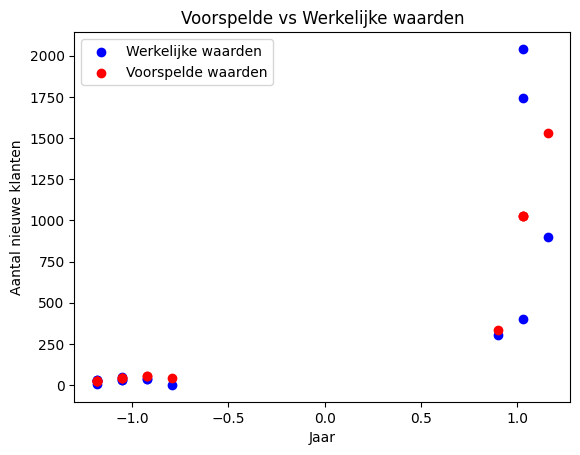

In [65]:
import matplotlib.pyplot as plt

# Plot werkelijke waarden
plt.scatter(X_test['Year'], y_test, color='blue', label='Werkelijke waarden')

# Plot voorspelde waarden
plt.scatter(X_test['Year'], ensemble_pred, color='red', label='Voorspelde waarden')

plt.title('Voorspelde vs Werkelijke waarden')
plt.xlabel('Jaar')
plt.ylabel('Aantal nieuwe klanten')
plt.legend()
plt.show()

# Regressiemodel trainen (zonder feature engineering)

In [66]:
#Voeg season toe
new_customers_per_month['Year'] = new_customers_per_month['YearMonth'].dt.year

# Selecteer de features en target
X = new_customers_per_month[['Year']]
y = new_customers_per_month['NewCustomers']

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train het model
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

# Voorspel het aantal nieuwe klanten
predictions = model.predict(X_test)

# Bereken de nauwkeurigheid van het model
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, predictions)
print(f"Mean Absolute Error: {mae}")

Mean Absolute Error: 244.9459134243807


# Data visualiseren

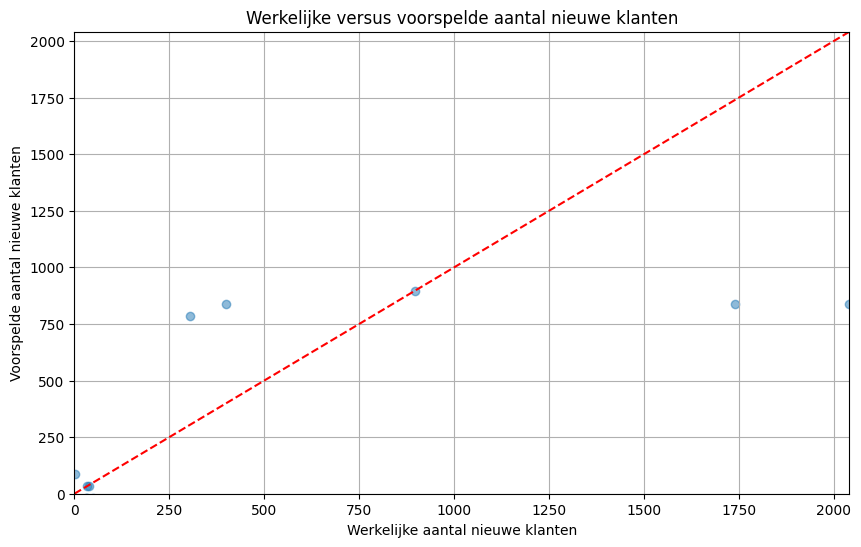

In [67]:
import matplotlib.pyplot as plt

# Visualiseer het werkelijke versus voorspelde aantal nieuwe klanten
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.xlabel('Werkelijke aantal nieuwe klanten')
plt.ylabel('Voorspelde aantal nieuwe klanten')
plt.title('Werkelijke versus voorspelde aantal nieuwe klanten')
plt.grid(True)
plt.xlim([0, max(y_test.max(), predictions.max())])
plt.ylim([0, max(y_test.max(), predictions.max())])
plt.plot([0, max(y_test.max(), predictions.max())], [0, max(y_test.max(), predictions.max())], color='red', linestyle='--')
plt.show()

# conclusie
De resultaten per maand waren niet erg accuraat. Ik denk dat dit komt door de kleine hoeveelheid data. Zelfs toen ik hierop Feature Engineering toepaste was de mae boven de 500.

De resultaten per jaar zijn accurater. De mae is nog steeds boven de 200 maar zoals we in de sctatterplot kunnen zien zijn de voorspellingen relatief accuraat met de werkelijkheid.

met feature engineering was de voorspelling iets accurater.